In [1]:
using Pkg; Pkg.status()

Project MixedModelsTutorials v0.1.0
    Status `~/.juliapro/JuliaPro_v1.1.1.1/dev/MixedModelsTutorials/Project.toml`
  [a93c6f00] + DataFrames v0.18.4
  [31c24e10] + Distributions v0.20.0
  [f6369f11] + ForwardDiff v0.10.3
  [7073ff75] + IJulia v1.18.1
  [91a5bcdd] + Plots v0.25.3
  [ce6b1742] + RDatasets v0.6.2
  [3eaba693] + StatsModels v0.6.1
  [f3b207a7] + StatsPlots v0.11.0
  [bd369af6] + Tables v0.2.8
  [44d3d7a6] + Weave v0.9.1
  [e88e6eb3] + Zygote v0.3.2
  [b77e0a4c] + InteractiveUtils 
  [37e2e46d] + LinearAlgebra 
  [44cfe95a] + Pkg 


# Nonlinear regression using automatic differentiation

Nonlinear regression or nonlinear least squares fits the parameters of a _model function_ to a vector of _observed responses_ and corresponding values of _covariates_.  Typically the data are organized in a table such as a `DataFrame`.

A simple example from enzyme kinetics relates the rate or velocity, `v`, of an enzymatic reaction to the concentration, `c`, of the substrate according to the _Michaelis-Menten_ model
\begin{equation}
v = \frac{V_m\,c}{K+c}
\end{equation}
The parameters of the model are $V_m$, the maximum velocity, and $K$, the Michaelis parameter.  Data from such an experiment is available in the `RDatasets` package.  There are actually two experiments.  We will concentrate on the data for the treated cells.

In [29]:
using BenchmarkTools, DataFrames, ForwardDiff, LinearAlgebra
using RDatasets, StatsPlots, Tables, Zygote

In [3]:
gr();

In [4]:
Pur = groupby(RDatasets.dataset("datasets", "Puromycin"), :State)

,Conc,Rate,State
,Float64,Int32,Categorical…
1,0.02,76,treated
2,0.02,47,treated
3,0.06,97,treated
4,0.06,107,treated
5,0.11,123,treated
6,0.11,139,treated
7,0.22,159,treated
8,0.22,152,treated
9,0.56,191,treated


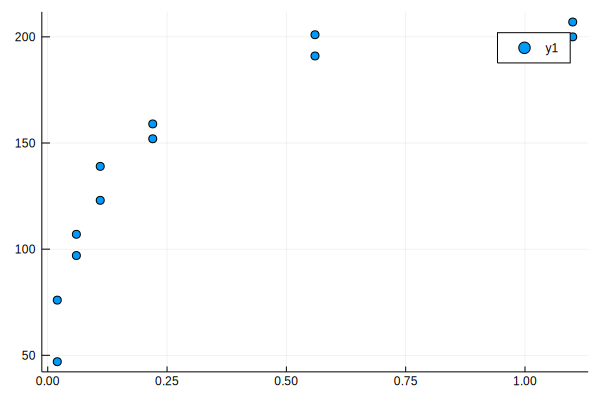

In [5]:
@df Pur[1] scatter(:Conc, :Rate)

As can be seen from the plot, the maximum velocity is around 200 and the Michaels parameter, `K`, which is the concentration at which the velocity is half the maximum, is about 0.05.

## Evaluating the mean vector and the Jacobian

In the statistical model the response vector, $\mathbf{y}$, is the realization of a random variable, $\mathcal{Y}$, that has a "spherical" Gaussian distribution with mean, $\mathbf{\mu}$, determined from the mean function, $\mathbf{\mu}(\mathbf{\theta},\mathbf{C})$, where $\mathbf{\theta}$ is the parameter vector and $\mathbf{C}$ is the table of covariate values.
\begin{equation}
\mathcal{Y}\sim\mathcal{N}\left(\mathbf{\mu}(\mathbf{\theta},\mathbf{C}),\sigma^2\mathbf{I}\right)
\end{equation}

The maximum likelihood estimates of $\mathbf{\theta}$ are the values that minimize the sum of squared residuals
\begin{equation}
\widehat{\mathbf{\theta}}=\arg\min_{\mathbf{\theta}} \|\mathbf{y}-\mathbf{\mu}(\mathbf{\theta},\mathbf{C})\|^2
\end{equation}

A simple iterative scheme for this _nonlinear least squares_ problem is the _Gauss-Newton_ method of successive linear approximation.  Writing $\mathbf{\mu}^{(i)}$ for the value of the mean vector at the $i$ iterate, $\mathbf{\theta}^{(i)}$ the increment is the linear least squares solution of the residual, $\mathbf{r}^{(i)}=\mathbf{y}-\mathbf{\mu}^{(i)}$, on the Jacobian, $\mathbf{J}^{(i)}=\partial\mathbf{\mu}(\mathbf{\theta},\mathbf{C})/\partial\mathbf{\theta}|_{\mathbf{\theta}^{(i)}}$
\begin{equation}
\mathbf{\mathbf{\delta}^{(i)}}=\arg\min_{\mathbf{\delta}}\|\mathbf{r}^{(i)}-\mathbf{J}^{(i)}\mathbf{\delta}\|^2
\end{equation}

### Vector evaluation

In the example the mean function could be written for vector evaluation using dot-broadcast fusion

In [6]:
μ(Vm, K, conc) = @. Vm * conc / (K + conc)

μ (generic function with 1 method)

producing the residual

In [7]:
r = Pur[1].Rate - μ(200., 0.05, Pur[1].Conc)

12-element Array{Float64,1}:
  18.85714285714286  
 -10.142857142857139 
 -12.090909090909093 
  -2.0909090909090935
 -14.5               
   1.5               
  -3.962962962962962 
 -10.962962962962962 
   7.393442622950829 
  17.39344262295083  
  15.695652173913032 
   8.695652173913032 

The `ForwardDiff` package can provide the Jacobian but it requires a unary function on which to operate.  This means that the parameters must be passed as an `AbstractVector` and the covariates must be in the closure of the function passed to, say, `ForwardDiff.jacobian!`.  Some applications require reuse of the model function for different sets of covariates, such as the treated and untreated cells here, and I think that means using a reference to the data table when defining the model function.

In [ ]:
const dataref = Ref(first(Pur))
function μ₁(pars)
    Vm, K = pars
    conc = dataref[].Conc
    @. Vm * conc / (K + conc)
end
const θ = [200., 0.05]
const results = DiffResults.JacobianResult(dataref[].Conc, θ)
const cfg = ForwardDiff.JacobianConfig(μ₁, θ)

In [17]:
ForwardDiff.jacobian!(results, μ₁, θ, cfg)
adjoint(results.value)

1×12 Adjoint{Float64,Array{Float64,1}}:
 57.1429  57.1429  109.091  109.091  …  183.607  183.607  191.304  191.304

In [18]:
results.derivs[1]

12×2 Array{Float64,2}:
 0.285714  -816.327
 0.285714  -816.327
 0.545455  -991.736
 0.545455  -991.736
 0.6875    -859.375
 0.6875    -859.375
 0.814815  -603.567
 0.814815  -603.567
 0.918033  -300.994
 0.918033  -300.994
 0.956522  -166.352
 0.956522  -166.352

In [19]:
map!(-, results.value, dataref[].Rate, results.value) # replace μ by residual

12-element Array{Float64,1}:
  18.85714285714286  
 -10.142857142857139 
 -12.090909090909093 
  -2.0909090909090935
 -14.5               
   1.5               
  -3.962962962962962 
 -10.962962962962962 
   7.393442622950829 
  17.39344262295083  
  15.695652173913032 
   8.695652173913032 

In [20]:
sum(abs2, results.value)                 # current sum of squared residuals

1636.5857075901783

In [21]:
δ = qr(results.derivs[1])\results.value

2-element Array{Float64,1}:
 11.157219609869895   
  0.011627130326972698

In [22]:
θ .+= δ

2-element Array{Float64,1}:
 211.15721960986988  
   0.0616271303269727

In [23]:
ForwardDiff.jacobian!(results, μ₁, θ, cfg)
sum(abs2, map!(-, results.value, dataref[].Rate, results.value))

1205.6196313926841

To change to a new data table, reassign `dataref[]` and create a new `JacobianResult`.

In [11]:
dataref[] = last(Pur)
const res2 = DiffResults.JacobianResult(dataref[].Conc, θ)
ForwardDiff.jacobian!(res2, μ₁, θ, cfg)
adjoint(res2.value)

1×11 LinearAlgebra.Adjoint{Float64,Array{Float64,1}}:
 57.1429  57.1429  109.091  109.091  …  162.963  183.607  183.607  191.304

In [12]:
res2.derivs[1]

11×2 Array{Float64,2}:
 0.285714  -816.327
 0.285714  -816.327
 0.545455  -991.736
 0.545455  -991.736
 0.6875    -859.375
 0.6875    -859.375
 0.814815  -603.567
 0.814815  -603.567
 0.918033  -300.994
 0.918033  -300.994
 0.956522  -166.352

Of course, these computations can be made cleaner by defining a data structure and operating on the struct but it seems to be tricky to get the closure of the model function right, if the model function is to be an element of the struct.  Because of lexical scoping the closure is defined at the time the function is defined.

## Scalar evaluation

In [ ]:
struct NLregData{T} where {T<:AbstractFloat}
    μ::Function
    dat::AbstractDataFrame
    y::AbstractVector{T}
    θ::AbstractVector{T}
    results::DiffResults.JacobianResult

As all the cool kids are switching to the `Zygote` package for automatic differentiation, I read up on that.  As far as I can see, Zygote is primarily used to evaluate gradients of scalar functions.

To iterate over the rows of the data frame, it is probably worthwhile to convert it to a rowtable.  Similarly, the matrix factor for evaluating the increment can be generated from the rows using `LinearAlgebra.lowrankupdate!`.

In [25]:
const rt = rowtable(first(Pur))
const ch = cholesky(zeros(3, 3) + I)
const v = zeros(3);

3-element Array{Float64,1}:
 0.0
 0.0
 0.0

In [26]:
function updatech!(ch::Cholesky{T, Matrix{T}}, θ::AbstractVector{T}, rowtbl, v::Vector{T}) where {T}
    rss = zero(T)             # residual sum of squares
    fill!(ch.factors, false)
    Vm, K = θ
    for r in rowtbl
        copyto!(v, gradient((Vm, K) -> μ(Vm, K, r.Conc), Vm, K))
        resid = r.Rate - μ(Vm, K, r.Conc)
        rss += abs2(resid)
        v[end] = resid
        lowrankupdate!(ch, v)
    end
    rss
end

updatech! (generic function with 1 method)

In [27]:
updatech!(ch, θ, rt, v)  # returns sum of squared residuals at current θ

1205.6196313926841

In [28]:
ch

Cholesky{Float64,Array{Float64,2}}
U factor:
3×3 UpperTriangular{Float64,Array{Float64,2}}:
 2.46279  -1607.44   -0.225002
  ⋅        1364.85    3.02266 
  ⋅            ⋅    -34.5895  

In [30]:
ldiv!(LowerTriangular(view(ch.factors, 1:2, 1:2)), copyto!(δ, view(ch.factors, 1:2, 3)))

2-element Array{Float64,1}:
 -0.09136051999062601 
  0.002214648452543934

As I understand it, `Zygote.forwarddiff` could be a better choice of AD algorithm but I don't quite understand how to use it.  I thought it could work like this but it doesn't

In [31]:
function forwardupdate!(ch::Cholesky{T, Matrix{T}}, θ::AbstractVector{T}, rowtbl, v::Vector{T}) where {T}
    rss = zero(T)             # residual sum of squares
    fill!(ch.factors, false)  # zero out the Cholesky factor
    for r in rowtbl
        copyto!(v, Zygote.forwarddiff(θ -> μ(θ[1], θ[2], r.Conc), θ))
        resid = r.Rate - μ(θ[1], θ[2], r.Conc)
        rss += abs2(resid)
        v[end] = resid
        lowrankupdate!(ch, v)
    end
    rss
end

forwardupdate! (generic function with 1 method)

In [32]:
forwardupdate!(ch, θ, rt, v)

1205.6196313926841

In [33]:
ch

Cholesky{Float64,Array{Float64,2}}
U factor:
3×3 UpperTriangular{Float64,Array{Float64,2}}:
 520.036   466.663  -0.225002
    ⋅     1086.95   14.9687  
    ⋅         ⋅     31.329   

Of course the `updatech!` function is sufficiently fast that it is not a problem to use the reverse mode AD.  I am just concerned that I may be using a sledgehammer to 

In [34]:
@benchmark updatech!($ch, $θ, $rt, $v)

BenchmarkTools.Trial: 
  memory estimate:  4.69 KiB
  allocs estimate:  36
  --------------
  minimum time:     4.195 μs (0.00% GC)
  median time:      4.275 μs (0.00% GC)
  mean time:        5.006 μs (11.43% GC)
  maximum time:     470.218 μs (98.05% GC)
  --------------
  samples:          10000
  evals/sample:     7